In [1]:
# Install required libraries
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
# Import fastbook
from fastbook import *

# Load Cifar dataset 
from fastai.vision.all import *
path = untar_data(URLs.CIFAR)

In [4]:
# Load the data into DataLoader objects
dblock = DataBlock(blocks=(ImageBlock(), CategoryBlock()), get_items=get_image_files, get_y=parent_label, item_tfms=Resize(460), batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = dblock.dataloaders(path, bs=64)

In [5]:
# Train the model using ResNet50
rsnt_model = xresnet50()
learn = Learner(dls, rsnt_model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.430894,1.906714,0.401500,11:09
1,1.033549,1.046034,0.629833,11:06
2,0.793301,0.843580,0.711500,11:06
3,0.620378,0.583736,0.796417,11:07
4,0.527582,0.512798,0.824250,11:08


In [6]:
# Normalization
x,y = dls.one_batch()
x.mean(dim=[0,2,3]),x.std(dim=[0,2,3])

(TensorImage([0.4706, 0.4661, 0.4465], device='cuda:0'),
 TensorImage([0.2581, 0.2598, 0.2763], device='cuda:0'))

In [7]:
def get_dls(bs, size):
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=get_image_files,
                   get_y=parent_label,
                   item_tfms=Resize(460),
                   batch_tfms=[*aug_transforms(size=size, min_scale=0.75),
                               Normalize.from_stats(*cifar_stats)])
    return dblock.dataloaders(path, bs=bs)

In [8]:
dls = get_dls(64, 224)

In [9]:
# Check the mean and standard deviation after normalization
x,y = dls.one_batch()
x.mean(dim=[0,2,3]),x.std(dim=[0,2,3])

(TensorImage([ 0.0394, -0.0134, -0.0387], device='cuda:0'),
 TensorImage([0.9623, 0.9841, 0.9554], device='cuda:0'))

In [10]:
# Train the model 
model = xresnet50()
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.424637,1.716498,0.413750,11:08
1,1.028185,1.024531,0.636000,11:08
2,0.804904,0.764113,0.733000,11:08
3,0.609056,0.540615,0.810917,11:08
4,0.519125,0.483907,0.832250,11:14


In [11]:
# Train the model on multiple batches (Progressive resizing)
dls = get_dls(128, 128)
learn = Learner(dls, xresnet50(), loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn.fit_one_cycle(4, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.344674,1.266041,0.548083,05:06
1,0.922638,1.055648,0.632000,05:07
2,0.653384,0.575052,0.801583,04:59
3,0.505418,0.475682,0.840583,04:54


In [12]:
# Replace the DataLoaders inside Learners 
learn.dls = get_dls(64, 224)
learn.fine_tune(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.690791,0.681267,0.763167,11:16


epoch,train_loss,valid_loss,accuracy,time
0,0.528962,0.489661,0.831583,11:17
1,0.487093,0.448520,0.841833,11:13
2,0.453208,0.413276,0.852833,11:12
3,0.327653,0.317869,0.889917,11:11
4,0.313395,0.300517,0.895167,11:09


Test Time Augmentation 

In [13]:
# Test time augmentation 
preds,targs = learn.tta()
accuracy(preds, targs).item()

0.9011666774749756

MixUp

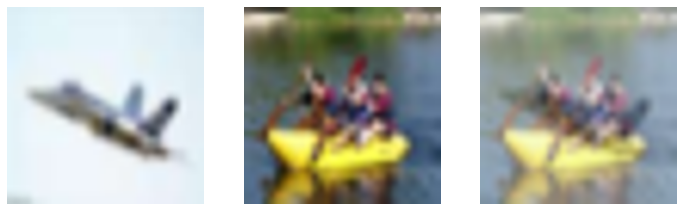

In [17]:
# Perform MixUp
# Caption Mixing a Airplane and a Ship

airplane = PILImage.create(get_image_files_sorted(path/'train'/'airplane')[0])
ship = PILImage.create(get_image_files_sorted(path/'train'/'ship')[0])
airplane = airplane.resize((256,256))
ship = ship.resize((256,256))
tairplane = tensor(airplane).float() / 255.
tship = tensor(ship).float() / 255.

_,axs = plt.subplots(1, 3, figsize=(12,4))
show_image(tairplane, ax=axs[0]);
show_image(tship, ax=axs[1]);
show_image((0.4*tairplane + 0.6*tship), ax=axs[2]);


Label Smoothing

In [18]:
# Perform Label Smoothing
dblock = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                   get_items=get_image_files,
                   get_y=parent_label,
                   item_tfms=Resize(460),
                   batch_tfms=aug_transforms(size=224, min_scale=0.80))
dls = dblock.dataloaders(path, bs=64)
model = xresnet50()
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropy(), 
                metrics=accuracy)
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.318040,2.685288,0.429333,11:13
1,1.938626,3.197423,0.394167,11:10
2,1.685172,1.639947,0.764333,11:10
3,1.541466,1.491136,0.824750,11:09
4,1.468287,1.443747,0.846167,11:09
